In [144]:
# usual packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [145]:
# machine learning packages
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

In [146]:
#COSMOS = pd.read_csv('match_COSMOS_999.txt')
cosmos = pd.read_csv('match_COSMOS_99_with_err_1.csv')
cosmos=cosmos.loc[:,["B_MAG_APER2","H_MAG_APER2","Hw_MAG_APER2","IA484_MAG_APER2","IA527_MAG_APER2","IA624_MAG_APER2",
            "IA679_MAG_APER2","IA738_MAG_APER2","IA767_MAG_APER2","IB427_MAG_APER2","IB464_MAG_APER2","IB505_MAG_APER2",
            "IB574_MAG_APER2","IB709_MAG_APER2","IB827_MAG_APER2","J_MAG_APER2","Ks_MAG_APER2","Ksw_MAG_APER2",
            "NB711_MAG_APER2","NB816_MAG_APER2","SPLASH_1_MAG","SPLASH_2_MAG","SPLASH_3_MAG","SPLASH_4_MAG","V_MAG_APER2",
            "Y_MAG_APER2","ip_MAG_APER2","r_MAG_APER2","yHSC_MAG_APER2","zpp_MAG_APER2",'zspec']]

In [147]:
def dataprocess(df, zspec_drop=True, magnitude_drop=True):
    
    df_new=df.copy()
    print(df_new.shape)
    df_new=df_new.replace({-99.9:df_new.mean()})
    if (magnitude_drop==True):
        df_new=df_new[(df_new["IA767_MAG_APER2"]<=22.7) & ( df_new["IA767_MAG_APER2"]>=16.5)]
        
    if (zspec_drop == True):
        df_new=df_new[(df_new['zspec']>0)&(df_new['zspec']<1)]
        
#     print(df_new.head(10))
    return df_new.iloc[:,:-1] , df_new.iloc[:,-1]

photo_bands,zspec=dataprocess(cosmos)



(391103, 31)


In [148]:
photo_bands_train,photo_bands_test, z_spec_train, z_spec_test = train_test_split(photo_bands, zspec, test_size=0.2)

In [149]:
N_estimators=20

In [150]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=N_estimators)
rf.fit(photo_bands_train,z_spec_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [151]:
X_train = photo_bands_test.values

sample_id = 0
tree_depths=[]
for j, estimator in enumerate(rf.estimators_):
    tree_depths.append(estimator.tree_.max_depth)
print('max depth of the tree is : ',np.asarray(tree_depths).max() )

   
#     n_nodes = estimator.tree_.node_count
#     children_left = estimator.tree_.children_left
#     children_right = estimator.tree_.children_right
#     feature = estimator.tree_.feature
#     threshold = estimator.tree_.threshold
    
#     node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
#     is_leaves = np.zeros(shape=n_nodes, dtype=bool)
#     stack = [(0, -1)]  # seed is the root node id and its parent depth
#     while len(stack) > 0:
#         node_id, parent_depth = stack.pop()
#         node_depth[node_id] = parent_depth + 1

#         # If we have a test node
#         if (children_left[node_id] != children_right[node_id]):
#             stack.append((children_left[node_id], parent_depth + 1))
#             stack.append((children_right[node_id], parent_depth + 1))
#         else:
#             is_leaves[node_id] = True

#     print("The binary tree structure has %s nodes and has "
#           "the following tree structure:"
#           % n_nodes)
#     for i in range(n_nodes):
#         if is_leaves[i]:
#             print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
#         else:
#             print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
#                   "node %s."
#                   % (node_depth[i] * "\t",
#                      i,
#                      children_left[i],
#                      feature[i],
#                      threshold[i],
#                      children_right[i],
#                      ))


max depth of the tree is :  34


In [152]:
pre=rf.predict(photo_bands_test)

In [153]:
dict_zspec=dict(zip(z_spec_test,pre))
unique_ztest=np.unique(np.sort(z_spec_test))
bin_num=100
bin_length=int(len(uniq_ztest)/bin_num)
variances=[]
errors=[]
means=[]
bin_edges=[]
for i in range(bin_num):
    
    left_edge=i*bin_length
    right_edge=(i+1)*bin_length
    bin_edges.append(unique_ztest[left_edge])
    if(right_edge>(len(pre)-1)):
        right_edge=len(pre)-1
    bin_datas=[]
    for z_test in unique_ztest[left_edge:right_edge]:
        bin_datas.append(dict_zspec[z_test])
    bin_datas=np.asarray(bin_datas)
    
    mean=bin_datas.mean()
    variances.append(np.std(bin_datas))
    
    error=0
#     print('mean:',mean)
#     print(bin_datas)
    for z in bin_datas:
        error+=(z-mean)**2
    errors.append(error/len(bin_datas))
#     print(error/len(bin_datas))
bin_edges.append(unique_ztest[-1])

100


<BarContainer object of 100 artists>

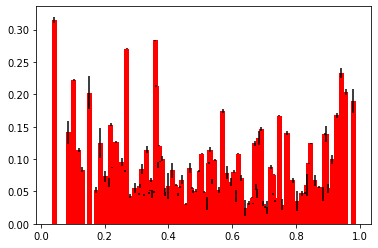

In [154]:
bincenters = 0.5*(np.asarray(bin_edges)[1:]+np.asarray(bin_edges)[:-1])
print(len(bincenters))
plt.bar(bincenters, variouses, width=0.016, color='r', yerr=errors)

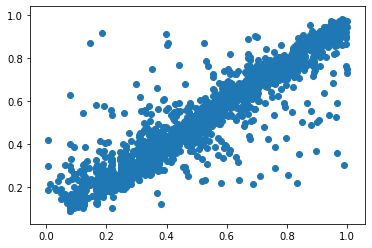

In [155]:
plt.scatter(z_spec_test,pre,size=.01)
plt.savefig('random_forest_dropped_mag')

In [156]:
len_pre=len(pre)
left_inteval=int(0.16*len_pre)
right_inteval=int(-0.16*len_pre)
center_pre=np.sort(np.asarray(pre))[left_inteval:right_inteval]
print(len(center_pre))
sum=0
mean=np.asarray(center_pre).mean()
for xi in center_pre:
    sum+=(xi-mean)**2
    sum/=len(center_pre)
print('variance is:'+str(sum) )


1908
variance is:3.1809161645123095e-05
